In [1]:
from keras.applications import VGG16
convBase = VGG16(weights = 'imagenet',
                include_top = False,
                input_shape=(150,150,3))
convBase.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
valDir = '/home/noah/Datasets/CatDog/validation'
testDir = '/home/noah/Datasets/CatDog/smallTest'
trainDir = '/home/noah/Datasets/CatDog/smallTrain'

datagen = ImageDataGenerator(rescale = 1.0/255)


batchSize = 20


def extractFeatures(path, nSamples):
    gen = datagen.flow_from_directory(path,
                                           target_size = (150,150),
                                            batch_size = 20,
                                           class_mode = 'binary')
    x = np.zeros(shape = (nSamples, 4,4,512))
    y = np.zeros(shape = (nSamples))
    
    i = 0
    for xBatch,yBatch in gen:
        try:
            prediction = convBase.predict(xBatch)
            x[i*batchSize:(i+1)*batchSize] = prediction
            y[i*batchSize:(i+1)*batchSize] = yBatch
            i+=1
            if(i>=nSamples/batchSize):
                break
        except:
            print(xBatch.shape)
    return x,y

testFeatures, testLabels = extractFeatures(testDir, 1000)        
trainFeatures, trainLabels = extractFeatures(trainDir, 2000)
valFeatures,valLabels = extractFeatures(valDir,1000)




Found 1000 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
testFeatures = testFeatures.reshape((1000,4*4*512))
trainFeatures = trainFeatures.reshape((2000,4*4*512))
valFeatures = valFeatures.reshape((1000,4*4*512))

In [12]:
from keras import models, layers, optimizers
model = models.Sequential()
model.add(layers.Dense(256,activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(trainFeatures,trainLabels, epochs = 30, batch_size = 20, validation_data = (valFeatures, valLabels))

Epoch 1/30
100/100 [==============================] - 1s 13ms/step - loss: 0.6181 - accuracy: 0.6540 - val_loss: 0.4328 - val_accuracy: 0.8290
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 0.4336 - accuracy: 0.8005 - val_loss: 0.3547 - val_accuracy: 0.8560
Epoch 3/30
100/100 [==============================] - 1s 13ms/step - loss: 0.3680 - accuracy: 0.8405 - val_loss: 0.3183 - val_accuracy: 0.8720
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.3330 - accuracy: 0.8575 - val_loss: 0.2981 - val_accuracy: 0.8690
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2983 - accuracy: 0.8815 - val_loss: 0.2785 - val_accuracy: 0.8740
Epoch 6/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2799 - accuracy: 0.8790 - val_loss: 0.2779 - val_accuracy: 0.8750
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2566 - accuracy: 0.8995 - val_loss: 0.2530 - val_accuracy: 0.8920

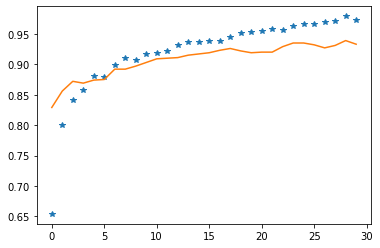

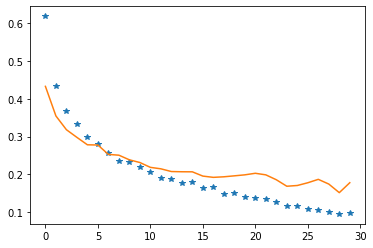

In [19]:
import matplotlib.pyplot as plt
history = hist.history
plt.plot(history['accuracy'],'*')
plt.plot(history['val_accuracy'])
plt.figure()

plt.plot(history['loss'],'*')
plt.plot(history['val_loss'])

In [23]:
model.summary()
for layer in model.layers:
    print(layer.name, layer.trainable)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
dense True
dropout True
dense_1 True


In [25]:
model.evaluate(testFeatures, testLabels)

32/32 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9470


[0.15997721254825592, 0.9470000267028809]

In [29]:
model.save('catsAndDogsvgg16.h5')